In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn.model_selection as ms
from xgboost import XGBRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor, OLSInfluence
from statsmodels.graphics.regressionplots import *
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn import neighbors
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)
sns.set(style = "whitegrid")
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#import df for linear models
train_dum_df = pd.read_csv('./Data/train_dum_df.csv', index_col=0)
test_dum_df = pd.read_csv('./Data/test_dum_df.csv', index_col=0)

In [3]:
#assign predictor and target variables
y = train_dum_df['SalePrice'].apply(np.log)
X = train_dum_df.drop(["SalePrice"], axis = 1)

In [4]:
#train/test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [5]:
#comparison dataframes for graphing
r2_scores = pd.DataFrame(columns=('Model', 'Score'))
rmse_scores = pd.DataFrame(columns=('Model','Score'))
mae_scores = pd.DataFrame(columns=('Model','Score'))

## Multiple Linear Regression

In [6]:
lr = LinearRegression()

lr.fit(X_train, y_train)
cv = np.mean(cross_val_score(lr, X_train, y_train, cv = 10))
pred = lr.predict(X_test)
RMSE = (mean_squared_error(pred, y_test, squared = False))
MAE = mean_absolute_error(pred,y_test)

print("R^2 train set: %f" %lr.score(X_train, y_train))
print("R^2 test  set: %f" %lr.score(X_test, y_test))
print("CV R^2 train set: " + str(round(cv,5)))
print("RMSE: " + str(round(RMSE, 5))) 
print("MAE: " + str(round(MAE, 5))) 

R^2 train set: 0.910181
R^2 test  set: 0.882335
CV R^2 train set: 0.84205
RMSE: 0.14128
MAE: 0.10219


In [7]:
#scores for graphing
#r2_scores.loc[0] = 'Multiple Linear Regression', round(lr2.score(X_test, y_test), 2)
rmse_scores.loc[0] = 'Multiple Linear Regression', round(RMSE, 4)
mae_scores.loc[0] = 'Multiple Linear Regression', round(MAE, 4)

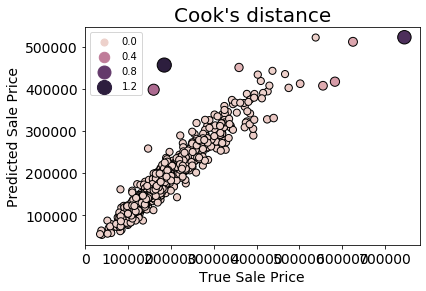

In [8]:
pred1 = lr.predict(X_train)
model = smf.ols('np.exp(y_train) ~ np.exp(pred1)', data=X_train).fit()

# calculate the cooks_distance - the OLSInfluence object contains multiple influence measurements
cook_distance = OLSInfluence(model).cooks_distance
(distance, p_value) = cook_distance

# scatter plot - x axis (independent variable height), y-axis (dependent variable weight), size and color of the marks according to its cook's distance
sns.scatterplot(x = np.exp(y_train), y = np.exp(pred1), hue=distance, size=distance, sizes=(50, 200), edgecolor='black', linewidth=1)

# ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# labels and title
plt.xlabel('True Sale Price', fontsize=14)
plt.ylabel('Predicted Sale Price', fontsize=14)
plt.title('Cook\'s distance', fontsize=20);

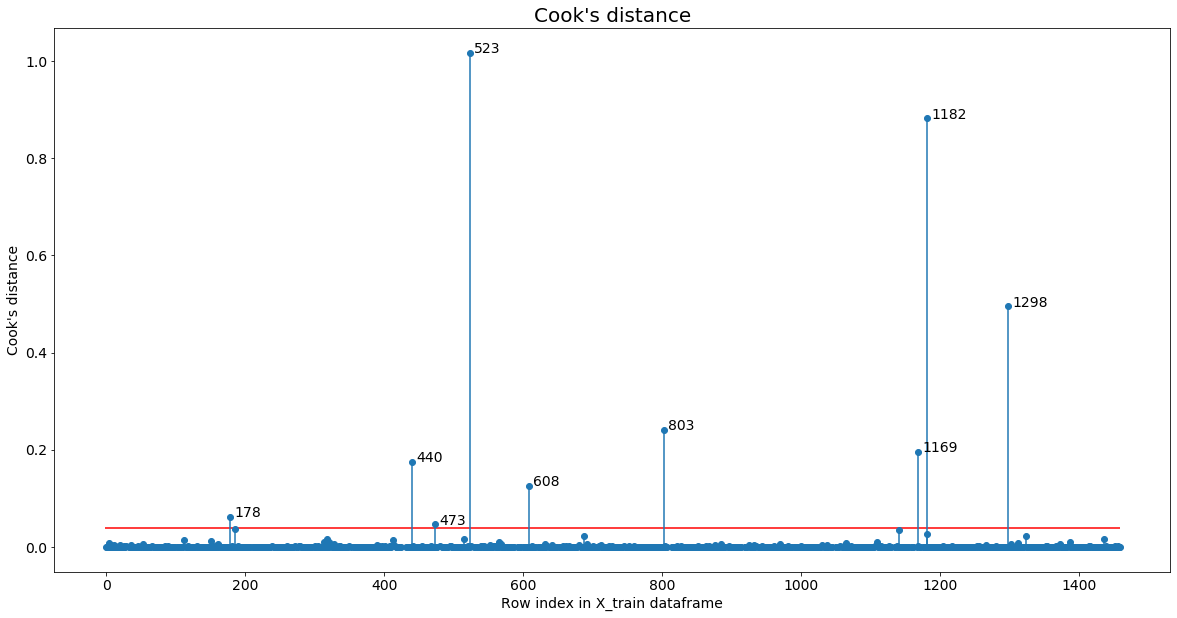

In [9]:
threshold = 4/100 # can change this
plt.figure(figsize=(20,10))
# stem plot - the x-axis represents the index of the observation and the y-axis its Cook's distance
plt.stem(distance.index, distance.values, basefmt=" ")

# horizontal line showing the threshold value
plt.hlines(threshold, -2, 1459, 'r')

# the observations with Cook's distances higher than the threshold value are labeled in the plot
influencial_data = distance[distance > threshold]

for index, value in influencial_data.items():
    plt.text(index + 6, value, str(index), fontsize=14)

# ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# labels and title
plt.xlabel('Row index in X_train dataframe', fontsize=14)
plt.ylabel('Cook\'s distance', fontsize=14)
plt.title('Cook\'s distance', fontsize=20);

In [10]:
# identify rows in X_train df that are influential outliers
X_train.loc[influencial_data.index,:]

,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,...,TotRmsAbvGrd,FireplaceQu,GarageFinish,GarageCars,GarageQual,Total_OutdoorSF,Baths,Age,AgeRemodAdd,AgeGarage
1182,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,10,3,3,3,3,249,5,11,11,11.0
178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9,4,3,3,3,60,3,1,0,0.0
523,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,11,4,3,3,3,614,5,0,-1,0.0
1298,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,12,4,3,2,3,506,5,0,0,0.0
440,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10,4,3,3,3,242,3,1,1,1.0
1169,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,10,3,3,3,3,437,5,11,10,11.0
803,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,12,4,2,3,3,414,4,1,0,0.0
473,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7,5,2,3,3,313,3,1,0,1.0
608,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,10,4,1,2,3,0,3,73,9,73.0


## Remove influential outliers and refit model

In [11]:
X_train_drop = X_train.drop(influencial_data.index, axis=0)
y_train_drop = y_train.drop(influencial_data.index, axis=0)

## Refit model with influential outliers removed

In [12]:
# using original threshold for influential outliers : 4/100, 
# gives the best values for the metrics
lr = LinearRegression()
lr.fit(X_train_drop, y_train_drop)

y_train_predicted = lr.predict(X_train_drop)
RMSE_train = np.sqrt(mean_squared_error(y_train_drop, y_train_predicted))
MAE_train = mean_absolute_error(y_train_drop, y_train_predicted)

y_test_predicted = lr.predict(X_test)
RMSE_test = np.sqrt(mean_squared_error(y_test,y_test_predicted))
MAE_test = mean_absolute_error(y_test,y_test_predicted)

#print("Best Lambda: " + str(alpha_lasso3))
print("R^2 train set: %f" %lr.score(X_train_drop, y_train_drop))
print("R^2 test set: %f" %lr.score(X_test, y_test))
print('-'*50)
print('RMSE for train data is: %.3f' % RMSE_train)
print('RMSE for test data is: %.3f' % RMSE_test)
print('-'*50)
print('MAE for train data is: %.3f' % MAE_train)
print('MAE for test data is: %.3f' % MAE_test)

R^2 train set: 0.930447
R^2 test set: 0.889927
--------------------------------------------------
RMSE for train data is: 0.101
RMSE for test data is: 0.137
--------------------------------------------------
MAE for train data is: 0.072
MAE for test data is: 0.097


In [13]:
#scores for graphing
#r2_scores.loc[0] = 'Multiple Linear Regression', round(lr2.score(X_test, y_test), 2)
rmse_scores.loc[0] = 'Multiple Linear Regression', round(RMSE_test, 4)
mae_scores.loc[0] = 'Multiple Linear Regression', round(MAE_test, 4)

## Lasso 

In [14]:
lasso = Lasso(normalize = True, max_iter = 10000)


alpha_100 = np.logspace(-7,-1, 100)
coef = []
for i in alpha_100:
    lasso.set_params(alpha = i)
    lasso.fit(X, y)
    coef.append(lasso.coef_)

Text(0, 0.5, 'coefficients')

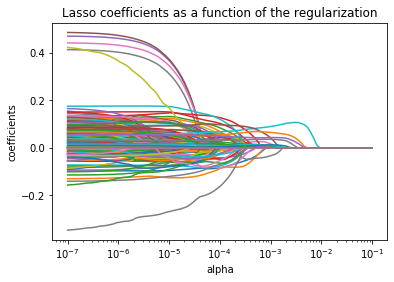

In [15]:
df_coef = pd.DataFrame(coef, index=alpha_100)
title = 'Lasso coefficients as a function of the regularization'
axes = df_coef.plot(logx = True, title=title, legend = False)
axes.set_xlabel('alpha')
axes.set_ylabel('coefficients')

In [16]:
lassocv = LassoCV(alphas = alpha_100, normalize = True, cv = 10, max_iter = 10000)

In [17]:
lassocv.fit(X_train, y_train)
alpha_lasso = lassocv.alpha_

y_train_predicted1 = lassocv.predict(X_train)
RMSE_train1 = np.sqrt(mean_squared_error(y_train,y_train_predicted1))

y_test_predicted1 = lassocv.predict(X_test)
RMSE_test1 = np.sqrt(mean_squared_error(y_test,y_test_predicted1))

print("Best Lambda: " + str(alpha_lasso))
print("R^2 train set: %f" %lassocv.score(X_train, y_train))
print("R^2 test set: %f" %lassocv.score(X_test, y_test))
print('RMSE for train data is: %.3f' % RMSE_train1)
print('RMSE for test data is: %.3f' % RMSE_test1)

Best Lambda: 0.00014174741629268049
R^2 train set: 0.892270
R^2 test set: 0.881130
RMSE for train data is: 0.129
RMSE for test data is: 0.142


In [18]:
lassocv_coef = pd.DataFrame(lassocv.coef_, index = X.columns).rename(columns = {0:"Coef."})
lassocv_imp = lassocv_coef[lassocv_coef["Coef."] > 0]
lassocv_imp = lassocv_coef.reindex(lassocv_coef["Coef."].abs().sort_values(ascending = False).index)
lassocv_imp.head(10)

,Coef.
Exterior1st_BrkComm,-0.187989
Neighborhood_StoneBr,0.125988
Neighborhood_Crawfor,0.117401
MSSubClass_30,-0.106239
CentralAir,0.098440
Neighborhood_NridgHt,0.092029
GarageCond_Po,0.088922
Neighborhood_NoRidge,0.085297
Exterior1st_BrkFace,0.084642
LotShape_IR3,-0.080876


## Feature Selection and Refitting MLR with influential outliers removed

In [19]:
imp_cols = lassocv_coef[lassocv_coef["Coef."] != 0].index.tolist()
print("Shape of Data set with only important features: " + str(X[imp_cols].shape))

Shape of Data set with only important features: (1460, 66)


In [20]:
y_train_drop_predicted = lassocv.predict(X_train_drop)

lr2 = LinearRegression()

lr2.fit(X_train_drop[imp_cols], y_train_drop)

y_train_predicted2 = lr2.predict(X_train_drop[imp_cols])
RMSE_train2 = np.sqrt(mean_squared_error(y_train_drop, y_train_predicted2))
MAE_train2 = mean_absolute_error(y_train_drop, y_train_predicted2)


y_test_predicted2 = lr2.predict(X_test[imp_cols])
RMSE_test2 = np.sqrt(mean_squared_error(y_test,y_test_predicted2))
MAE_test2 = mean_absolute_error(y_test,y_test_predicted2)


#print("Best Lambda: " + str(alpha_lasso3))
print("R^2 train set: %f" %lr2.score(X_train_drop[imp_cols], y_train_drop))
print("R^2 test set: %f" %lr2.score(X_test[imp_cols], y_test))
print('-'*50)
print('RMSE for train data is: %.3f' % RMSE_train2)
print('RMSE for test data is: %.3f' % RMSE_test2)
print('-'*50)
print('MAE for train data is: %.3f' % MAE_train2)
print('MAE for test data is: %.3f' % MAE_test2)

R^2 train set: 0.919379
R^2 test set: 0.888399
--------------------------------------------------
RMSE for train data is: 0.109
RMSE for test data is: 0.138
--------------------------------------------------
MAE for train data is: 0.079
MAE for test data is: 0.094


In [21]:
#scores for graphing
#r2_scores.loc[0] = 'Multiple Linear Regression', round(lr2.score(X_test, y_test), 2)
rmse_scores.loc[0] = 'Multiple Linear Regression', round(RMSE_test2, 4)
mae_scores.loc[0] = 'Multiple Linear Regression', round(MAE_test2, 4)

In [22]:
### LASSO 
lasso2 = Lasso()
lasso2.fit(X_train_drop[imp_cols], y_train_drop)

y_train_predicted3 = lasso2.predict(X_train_drop[imp_cols])
RMSE_train3 = np.sqrt(mean_squared_error(y_train_drop, y_train_predicted3))
MAE_train3 = mean_absolute_error(y_train_drop, y_train_predicted3)


y_test_predicted3 = lasso2.predict(X_test[imp_cols])
RMSE_test3 = np.sqrt(mean_squared_error(y_test,y_test_predicted3))
MAE_test3 = mean_absolute_error(y_test,y_test_predicted3)


#print("Best Lambda: " + str(alpha_lasso3))
print("R^2 train set: %f" %lasso2.score(X_train_drop[imp_cols], y_train_drop))
print("R^2 test set: %f" %lasso2.score(X_test[imp_cols], y_test))
print('-'*50)
print('RMSE for train data is: %.3f' % RMSE_train3)
print('RMSE for test data is: %.3f' % RMSE_test3)
print('-'*50)
print('MAE for train data is: %.3f' % MAE_train3)
print('MAE for test data is: %.3f' % MAE_test3)

R^2 train set: 0.786538
R^2 test set: 0.813613
--------------------------------------------------
RMSE for train data is: 0.177
RMSE for test data is: 0.178
--------------------------------------------------
MAE for train data is: 0.127
MAE for test data is: 0.127


In [23]:
#scores for graphing
#r2_scores.loc[1] = 'Lasso', round(lasso2.score(X_test, y_test), 2)
rmse_scores.loc[1] = 'Lasso', round(RMSE_test3, 4)
mae_scores.loc[1] = 'Lasso', round(MAE_test3, 4)

## Tree Based Models

In [24]:
#import df
train_undum_df = pd.read_csv('./Data/train_undum_df.csv', index_col=0)
test_undum_df = pd.read_csv('./Data/test_undum_df.csv', index_col=0)

In [25]:
#assign predictor and target variables
y = train_undum_df['SalePrice'].apply(np.log)
X = train_undum_df.drop(["SalePrice"], axis = 1)

In [26]:
#train/test split 
Xu_train, Xu_test, yu_train, yu_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

## Random Forest

In [27]:
# best parameters with lowered max_depth
rf = RandomForestRegressor(bootstrap= False,
                    ccp_alpha= 0.0,
                    criterion= 'mse',
                    max_depth= 4,
                    max_features= 8,
                    max_leaf_nodes= None,
                    max_samples= None,
                    min_samples_leaf= 1,
                    min_samples_split= 2,
                    n_estimators= 500,
                    random_state= 42)

rf.fit(Xu_train, yu_train)

RandomForestRegressor(bootstrap=False, max_depth=4, max_features=8,
                      n_estimators=500, random_state=42)

In [28]:
train_baseline_rf = rf.predict(Xu_train)
RMSE_train4 = np.sqrt(mean_squared_error(yu_train, train_baseline_rf))
MAE_train4 = mean_absolute_error(yu_train, train_baseline_rf)


test_baseline_rf = rf.predict(Xu_test)
RMSE_test4 = np.sqrt(mean_squared_error(yu_test,test_baseline_rf))
MAE_test4 = mean_absolute_error(yu_test,test_baseline_rf)

print("R^2 for train data is: %.3f" %(rf.score(Xu_train, yu_train)))
print("R^2 for test data is: %.3f" %(rf.score(Xu_test,yu_test)))
print("-" * 50)
print("RMSE for train data is: %.3f" % RMSE_train4)
print("RMSE for test data is: %.3f" % RMSE_test4)
print("-" * 50)
print("RMSE for train data is: %.4f" % MAE_train4)
print("RMSE for test data is: %.4f" % MAE_test4)

R^2 for train data is: 0.854
R^2 for test data is: 0.855
--------------------------------------------------
RMSE for train data is: 0.154
RMSE for test data is: 0.149
--------------------------------------------------
RMSE for train data is: 0.1083
RMSE for test data is: 0.1065


In [29]:
#scores for graphing
#r2_scores.loc[2] = 'Random Forest', round(rf.score(X_test, y_test), 2)
rmse_scores.loc[2] = 'Random Forest', round(RMSE_test4, 4)
mae_scores.loc[2] = 'Random Forest', round(MAE_test4, 4)

## Gradient Boosting

In [30]:
#manually lowered max depth 
gbm = GradientBoostingRegressor(n_estimators=500,
                                 learning_rate=0.01,
                                 max_depth=1,
                                 max_features=15)

gbm.fit(Xu_train, yu_train)

GradientBoostingRegressor(learning_rate=0.01, max_depth=1, max_features=15,
                          n_estimators=500)

In [31]:
train_baseline_gbm = gbm.predict(Xu_train)
RMSE_train5 = np.sqrt(mean_squared_error(yu_train, train_baseline_gbm))
MAE_train5 = mean_absolute_error(yu_train, train_baseline_gbm)


test_baseline_gbm = gbm.predict(Xu_test)
RMSE_test5 = np.sqrt(mean_squared_error(yu_test,test_baseline_gbm))
MAE_test5 = mean_absolute_error(yu_test,test_baseline_gbm)


print("Final Values: ")
print("R^2 for train data is: %.3f" %(gbm.score(Xu_train, yu_train)))
print("R^2 for test data is: %.3f" %(gbm.score(Xu_test,yu_test)))
print("-" * 50)
print("RMSE for train data is: %.3f" % RMSE_train5)
print("RMSE for test data is: %.3f" % RMSE_test5)
print("-" * 50)
print("MAE for train data is: %.4f" % MAE_train5)
print("MAE for test data is: %.4f" % MAE_test5)

Final Values: 
R^2 for train data is: 0.816
R^2 for test data is: 0.831
--------------------------------------------------
RMSE for train data is: 0.172
RMSE for test data is: 0.161
--------------------------------------------------
MAE for train data is: 0.1187
MAE for test data is: 0.1133


In [32]:
#scores for graphing
#r2_scores.loc[3] = 'Gradient Boost', round(gbm.score(X_test, y_test), 2)
rmse_scores.loc[3] = 'Gradient Boost', round(RMSE_test5, 4)
mae_scores.loc[3] = 'Gradient Boost', round(MAE_test5, 4)

## XG Boost

In [33]:
#manually lowered max depth 
xgb= XGBRegressor(colsample_bytree= 0.6,
                        gamma= 0.055,
                        learning_rate=0.095,
                        max_depth= 2,
                        min_child_weight= 1,
                        n_estimators= 150,
                        random_state=1,
                        reg_alpha= 0,
                        subsample= 0.3)
xgb.fit(Xu_train, yu_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0.055, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.095, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=150, n_jobs=0, num_parallel_tree=1, random_state=1,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.3,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [34]:
train_baseline_xgb = xgb.predict(Xu_train)
RMSE_train6 = np.sqrt(mean_squared_error(yu_train, train_baseline_xgb))
MAE_train6 = mean_absolute_error(yu_train, train_baseline_xgb)


test_baseline_xgb = xgb.predict(Xu_test)
RMSE_test6 = np.sqrt(mean_squared_error(yu_test,test_baseline_xgb))
MAE_test6 = mean_absolute_error(yu_test,test_baseline_xgb)


print("Final Values: ")
print("R^2 for train data is: %.3f" %(xgb.score(Xu_train, yu_train)))
print("R^2 for test data is: %.3f" %(xgb.score(Xu_test,yu_test)))
print("-" * 50)
print("RMSE for train data is: %.3f" % RMSE_train6)
print("RMSE for test data is: %.3f" % RMSE_test6)
print("-" * 50)
print("MAE for train data is: %.4f" % MAE_train6)
print("MAE for test data is: %.4f" % MAE_test6)


Final Values: 
R^2 for train data is: 0.921
R^2 for test data is: 0.885
--------------------------------------------------
RMSE for train data is: 0.113
RMSE for test data is: 0.133
--------------------------------------------------
MAE for train data is: 0.0843
MAE for test data is: 0.0980


In [35]:
#scores for graphing
#r2_scores.loc[4] = 'Gradient Boost', round(gbm.score(X_test, y_test), 2)
rmse_scores.loc[4] = 'XG Boost', round(RMSE_test6, 4)
mae_scores.loc[4] = 'XG Boost', round(MAE_test6, 4)

## Comparing Models

,Model,Score
0,Multiple Linear Regression,0.1376
1,Lasso,0.1778
2,Random Forest,0.1495
3,Gradient Boost,0.1614
4,XG Boost,0.1333


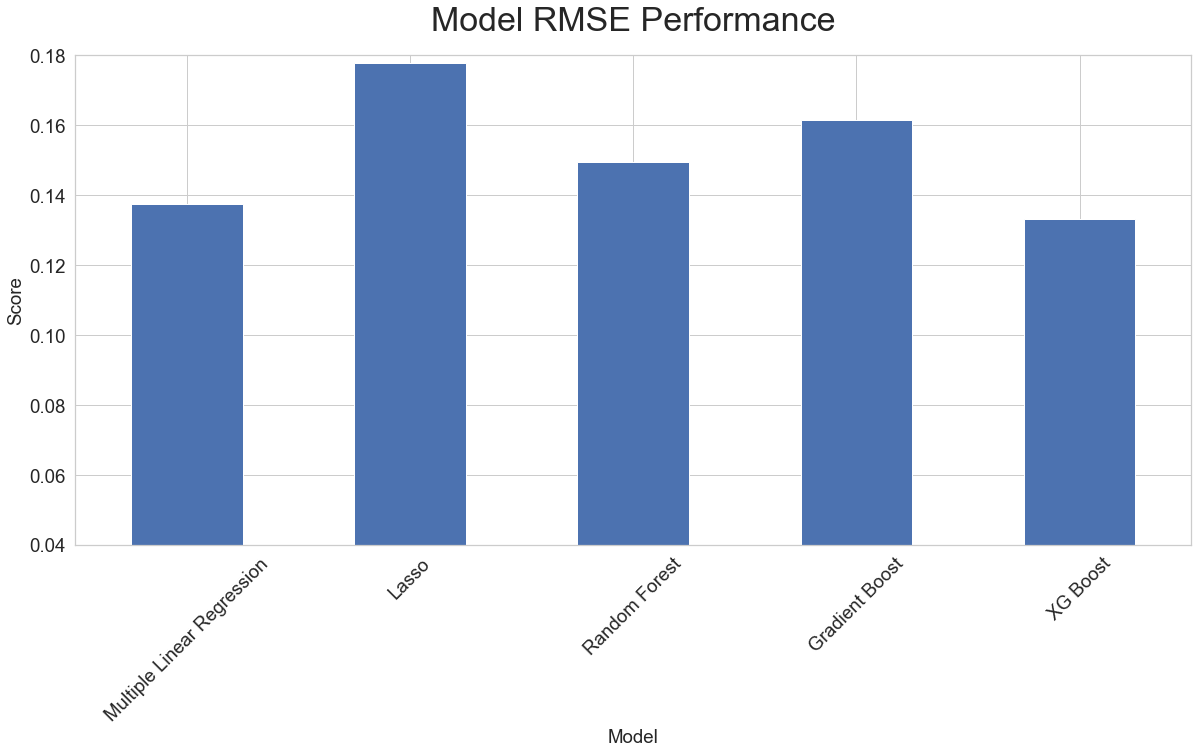

In [64]:
rmse_scores.plot.bar(x = 'Model', y ='Score', color = 'b',legend=None)
plt.title('Model RMSE Performance')
plt.ylim(.04,.18)
plt.ylabel('Score')
plt.xticks(rotation=45)
rmse_scores

,Model,Score
0,Multiple Linear Regression,0.0939
1,Lasso,0.1269
2,Random Forest,0.1065
3,Gradient Boost,0.1133
4,XG Boost,0.0980


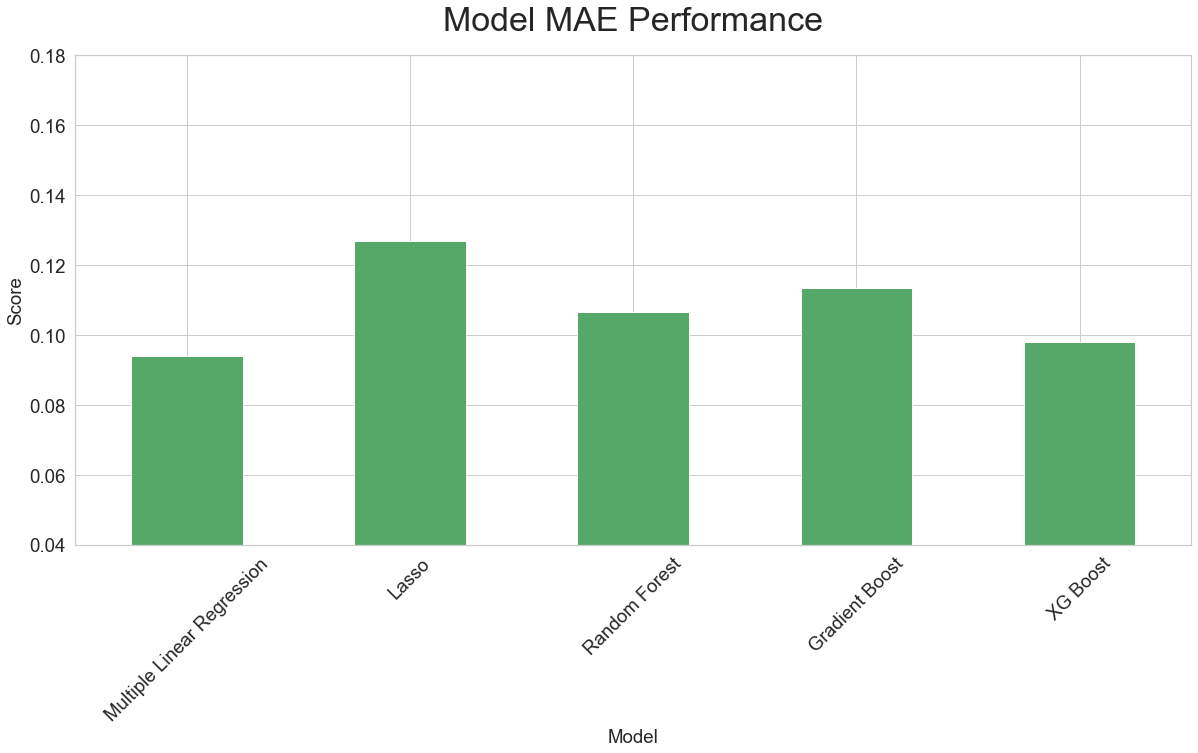

In [63]:
mae_scores.plot.bar(x = 'Model', y ='Score', color = 'g',legend=None)
plt.title('Model MAE Performance')
plt.ylim(.04,.18)
plt.ylabel('Score')
plt.xticks(rotation=45)
mae_scores